In [1]:
from Node import Node
from util import fetch_minibatch
import numpy as np
import tensorflow as tf
from time import time
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X_full = iris.data
y_full = np.eye(3)[iris.target]
n_features = X_full[0].shape[0]
n_classes = y_full[0].shape[0]

In [4]:
server_batch_size = 30

X_test, y_test = fetch_minibatch(X_full, y_full, server_batch_size)

with tf.Session() as sess:    
    Master = Node(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())
        
    print("untrained accuracy: ", Master.score(X_full, y_full))
    
    n_epochs = 20
    X_server, y_server = fetch_minibatch(X_full, y_full, server_batch_size)
    Master.fit(X_server, y_server, n_epochs)
    
    print("accuracy, using updated weights {0:.3f} ".format(Master.score(X_full, y_full)))
    
    server_w1 = Master.fetch_weights()

untrained accuracy:  0.333333
accuracy, using updated weights 0.667 


In [5]:
original_server_w1 = server_w1

round 0 execution time: 3.1388421058654785 accuracy: 0.8999999761581421
round 1 execution time: 2.8116440773010254 accuracy: 0.95333331823349
round 2 execution time: 2.782147169113159 accuracy: 0.9599999785423279
round 3 execution time: 2.7059502601623535 accuracy: 0.9599999785423279
round 4 execution time: 2.756247043609619 accuracy: 0.9666666388511658
round 5 execution time: 2.7820329666137695 accuracy: 0.9399999976158142
round 6 execution time: 2.8027403354644775 accuracy: 0.95333331823349
round 7 execution time: 2.7404510974884033 accuracy: 0.6666666865348816
round 8 execution time: 2.8029439449310303 accuracy: 0.95333331823349
round 9 execution time: 2.7011499404907227 accuracy: 0.6666666865348816
completed


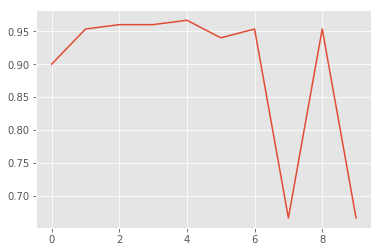

In [6]:
learning_rate = .1
n_epochs = 500
n_clients = 5
client_batch_size = 5
n_rounds = 10
ls_accuracy = []

with tf.Session() as sess:
    Worker = Node(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())
    
    for r in range(n_rounds):
        s = time()
        
        # each round needs a new average client weights
        ls_client_w1 = []
        
        for client in range(n_clients):

            # each client receives the same server weight
            client_w1 = server_w1

            # each client has their own minibatch
            X_client, y_client = fetch_minibatch(X_full, y_full, client_batch_size)
            
            # calculate term b gradient using (1) server weights and (2) client data
            term_b = Worker.fetch_grad(server_w1, X_client, y_client)
            
            # compute term c gradient using (1) server weights and (2) server data
            term_c = Worker.fetch_grad(server_w1, X_server, y_server)

            # client parameter updates
            for n in range(n_epochs):
                # compute term a gradient using (1) client weights and (2) client data
                term_a = Worker.fetch_grad(client_w1, X_client, y_client)

                # update client weights
                client_w1 = client_w1 - learning_rate * (term_a - term_b + term_c)

            # track weights for each client
            ls_client_w1.append(client_w1)
        
        # after all clients are accounted for, update server weights each round
        server_w1 = np.mean(ls_client_w1, axis=0)
        Worker.load(server_w1)
        acc = Worker.score(X_full, y_full)
        print("round {} execution time: {} accuracy: {}".format(r, time() - s, acc))
        ls_accuracy.append(acc)
    
print("completed")
plt.plot(ls_accuracy)

In [ ]:
with tf.Session() as sess:    
    Master = Client(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())
    
    Master.load(original_server_w1)
    print("untrained accuracy: ", Master.score(X_test, y_test))
    Master.load(server_w1)  # use average weights from clients
    print("accuracy, using updated weights: ", Master.score(X_test, y_test))